#  Part 1 -- Data Download

# 1a.  Use API to extract data from college football database


In the cell below we create a class that can be used to pass in the main url and the api key.  Once the object has been created we can use the method and give it the extension url and the params.  This will allow the user to receive data.

In [107]:
import matplotlib.pyplot as plt

In [108]:
import requests
import pandas as pd

class main:
  
  def __init__(self, api, endpoint):
    self.headers = {"Authorization": "Bearer " + api}
    self.endpoint = endpoint

class apis(main):

  def get(self,url,**params):
    """
    **params** 
    year 
    classification  (HighSchool, JUCO, PrepSchool)
    position Position abbreviation filter
    state State or province abbreviation filter
    team Committed team filter (required if year not specified)
    """

    #add at least (year,team) in the params)
    
    return requests.get(self.endpoint + url ,params = params, headers=self.headers).json()


# **Make a request for player data using the api object**

Notes:

Set the param key 'year' to a range from 2011 to 2023 

Read the data using json_normalize.  This makes columns that are not json objects split into more than one column in the dataframe.   Each year's df is then concatenated to get all the years required.

In [109]:
# Create API object
ob = apis("+VQyxTTt/o7Q9fNKeyBxjbQo8lb5AVfNJCnkfUN6QyVPWQ9nuWFlCeMplI60SUDB","https://api.collegefootballdata.com/")

# Get data for all players from 2011-23
df = pd.concat([pd.json_normalize(ob.get("recruiting/players",year=year)) for year in range(2011, 2024)])

# We can then save our primary dataset (of all college players) locally

In [110]:
# Save the primary dataset 
df.to_csv("nfl_data.csv")

In [111]:
# Review most recent items
df.tail()

,id,athleteId,recruitType,year,ranking,name,school,committedTo,position,height,weight,stars,rating,city,stateProvince,country,hometownInfo.latitude,hometownInfo.longitude,hometownInfo.fipsCode
2410,94996,None,HighSchool,2023,2298.0,Jacob Harris,Westerville Central,Bowling Green,WR,76.0,192.0,2,0.7844,Westerville,OH,USA,40.126139,-82.9295287,39049
2411,94488,None,HighSchool,2023,2299.0,Trey Dubuc,Cardinal Gibbons,South Florida,LS,74.0,220.0,2,0.7844,Fort Lauderdale,FL,USA,26.1223084,-80.1433786,12011
2412,95117,None,HighSchool,2023,2300.0,Ezekiel Rodrigues,Mililani,Hawai'i,S,73.0,190.0,2,0.7833,Mililani,HI,USA,21.4508308,-158.0095783,15003
2413,94810,None,HighSchool,2023,2301.0,DeAndre Beasley Jr.,Bishop Miege,None,CB,71.0,180.0,2,0.7800,Lees Summit,MO,USA,38.9107156,-94.3821295,29095
2414,94123,None,HighSchool,2023,2302.0,Brady Probst,Brownsburg,Illinois State,TE,76.0,235.0,2,0.7733,Brownsburg,IN,USA,39.8433769,-86.3977736,18063


# 1b. Next we download the two secondary datasets

One dataset can be downloaded from the cell below, while the other one needs to be downloaded through the link and then moved to the project directory 

In [112]:
# Download the income data files based on city and cities based on coordinates

"""
you will have to download the cities based on coordinates data
here is the link to it and move the file to the project directory

https://www.unitedstateszipcodes.org/zip_code_database.csv?download_auth=a5443d423dfb4db4fe077643f04b2f8c

"""
!wget https://www.irs.gov/pub/irs-soi/19zpallagi.csv


--2023-02-21 09:27:13--  https://www.irs.gov/pub/irs-soi/19zpallagi.csv
Resolving www.irs.gov (www.irs.gov)... 104.112.1.9
Connecting to www.irs.gov (www.irs.gov)|104.112.1.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: '19zpallagi.csv.20'

19zpallagi.csv.20       [        <=>         ] 190.40M  22.8MB/s    in 8.7s    

2023-02-21 09:27:22 (21.9 MB/s) - '19zpallagi.csv.20' saved [199650533]



# The "19zpallagi" dataset has only the income based on zip codes.

# The "zip_code_database" dataset has zip codes, cities, coordinates, etc.

In [113]:
# IRS income dataset
income = pd.read_csv("19zpallagi.csv")

# Coordinates with zip codes
zips_coordinates = pd.read_csv("zip_code_database.csv")

In [114]:
# Isolating and removing non-US recruits
non_us_players = [df['hometownInfo.latitude'].isna()]
df = df[df['hometownInfo.latitude'].isna() == False]

In [115]:
# Slimming down dfs for visual ease
relevant_columns_income = ['STATE', 'zipcode', 'A02650']

relevant_columns_linking_info = ['state', 'zip', 'primary_city', 'latitude', 'longitude']

income = income[relevant_columns_income]

zips_coordinates = zips_coordinates[relevant_columns_linking_info]

In [116]:
# Review first few items in zip code data
zips_coordinates.head()

,state,zip,primary_city,latitude,longitude
0,NY,501,Holtsville,40.81,-73.04
1,NY,544,Holtsville,40.81,-73.04
2,PR,601,Adjuntas,18.16,-66.72
3,PR,602,Aguada,18.38,-67.18
4,PR,603,Aguadilla,18.43,-67.15


In [117]:
# Review first few items in income df
income.head()

,STATE,zipcode,A02650
0,AL,0,10311099.0
1,AL,0,19145621.0
2,AL,0,17690402.0
3,AL,0,15670456.0
4,AL,0,35286228.0


# Merge two datasets -- the Income one and Zip_coordinates -- by zipcode.  Then groupby by zipcode and apply mean to the average income per household to get the mean income in a city. 

In [118]:
# Avg income by zipcode
median_income_by_zipcode = income.merge(zips_coordinates, left_on=['zipcode'], right_on=['zip']).groupby("zipcode").A02650.mean().reset_index()

In [119]:
# Merging with other info
merged_income_zipcor = zips_coordinates.merge(median_income_by_zipcode, left_on=['zip'], right_on=['zipcode'])

# We then create adjusted lat and adj lon columns.  These will be the key to the final merge.

In [120]:
# Create adjusted latitude and longitude cols for merging
merged_income_zipcor['adj_lat'] = merged_income_zipcor['latitude'].apply(lambda x: float(str(x).split(".")[0]))
merged_income_zipcor['adj_lng'] = merged_income_zipcor['longitude'].apply(lambda x: float(str(x).split(".")[0]))

In [121]:
# Get average income by city
income_by_city_state_coord = merged_income_zipcor.groupby(['primary_city', 'state', 'adj_lat', 'adj_lng']).A02650.mean().reset_index()
income_by_city_state_coord['A02650'] = income_by_city_state_coord['A02650'].round()
income_by_city_state_coord = income_by_city_state_coord.rename(columns={"A02650" : "Average Income"})

Change the newly created adj_latitude and adj_longitude columns to float and round

In [122]:
df['lat_adj'] = df['hometownInfo.latitude'].apply(lambda x: float(str(x).split(".")[0]))
df['lng_adj'] = df['hometownInfo.longitude'].apply(lambda x: float(str(x).split(".")[0]))

In [123]:
# Review df
df.head()

,id,athleteId,recruitType,year,ranking,name,school,committedTo,position,height,...,stars,rating,city,stateProvince,country,hometownInfo.latitude,hometownInfo.longitude,hometownInfo.fipsCode,lat_adj,lng_adj
0,19571,-1032080,HighSchool,2011,1.0,Jadeveon Clowney,South Pointe,South Carolina,WDE,77.0,...,5,1.0000,Rock Hill,SC,USA,34.9248667,-81.0250784,45091,34.0,-81.0
1,19572,-1000934,HighSchool,2011,2.0,Cyrus Kouandjio,DeMatha Catholic,Alabama,OT,79.0,...,5,0.9993,Hyattsville,MD,USA,38.9529442,-76.9408647,24033,38.0,-76.0
2,19573,-1016566,HighSchool,2011,3.0,La'el Collins,Redemptorist,LSU,OT,77.0,...,5,0.9976,Baton Rouge,LA,USA,30.4459596,-91.18738,22033,30.0,-91.0
3,19574,517390,HighSchool,2011,4.0,Karlos Williams,Ridge Community,Florida State,S,74.0,...,5,0.9976,Davenport,FL,USA,28.1614046,-81.6017417,12105,28.0,-81.0
4,19575,517222,HighSchool,2011,5.0,Anthony Johnson,O Perry Walker,LSU,DT,75.0,...,5,0.9973,New Orleans,LA,USA,29.9499323,-90.0701156,22071,29.0,-90.0


# Finally we can create the final combined database

In [124]:
# Create final df using merge

final = df.merge(income_by_city_state_coord, left_on=['city', 'stateProvince', 'lat_adj', 'lng_adj'],
                                       right_on=['primary_city', 'state', 'adj_lat', 'adj_lng'])

In [125]:
# Review final df
final.tail()

,id,athleteId,recruitType,year,ranking,name,school,committedTo,position,height,...,hometownInfo.latitude,hometownInfo.longitude,hometownInfo.fipsCode,lat_adj,lng_adj,primary_city,state,adj_lat,adj_lng,Average Income
42998,94925,None,HighSchool,2023,2148.0,Tell Wade,Wray,Wyoming,DL,74.0,...,40.0758231,-102.2232494,08125,40.0,-102.0,Wray,CO,40.0,-102.0,17264.0
42999,94242,None,HighSchool,2023,2180.0,Cedric Hawkins,Stuttgart,Arkansas State,RB,68.0,...,34.5003748,-91.5526281,05001,34.0,-91.0,Stuttgart,AR,34.0,-91.0,42326.0
43000,94603,None,HighSchool,2023,2198.0,Maurice Long,South Point,Akron,OT,78.0,...,38.4178597,-82.5862699,39087,38.0,-82.0,South Point,OH,38.0,-82.0,42809.0
43001,94608,None,HighSchool,2023,2230.0,Rory Callahan,Huron,Central Michigan,TE,76.0,...,42.1625408,-83.4029885,26163,42.0,-83.0,New Boston,MI,42.0,-83.0,61554.0
43002,94619,None,HighSchool,2023,2273.0,John Burke,Sault Area,Central Michigan,IOL,75.0,...,46.490586,-84.359269,26033,46.0,-84.0,Sault Sainte Marie,MI,46.0,-84.0,73104.0


In [126]:
# Review columns in final df
final.columns

Index(['id', 'athleteId', 'recruitType', 'year', 'ranking', 'name', 'school',
       'committedTo', 'position', 'height', 'weight', 'stars', 'rating',
       'city', 'stateProvince', 'country', 'hometownInfo.latitude',
       'hometownInfo.longitude', 'hometownInfo.fipsCode', 'lat_adj', 'lng_adj',
       'primary_city', 'state', 'adj_lat', 'adj_lng', 'Average Income'],
      dtype='object')

#  Part 2.  In-Depth Positional And Team Analysis

# Create a new  income_level column and use it to calculate the number of players in each third/quartile/decile based on the following brackets:

"High" Income = Greater than 156,600, "Middle" Income = Between 52,200 - 156,600, "Low" Income = Less than 52,200 

In [127]:
import numpy as np
#making an income level column that has either 'high','medium' or 'low'  ('high' is greater than 156600) ('low' is less than 52200)

income_level = np.where(final['Average Income'] >156600, 'high',np.where(final['Average Income'] < 52200,'low','middle' ))
final['income_level'] = income_level

# Show the number of players based on specified income levels

In [128]:
# calculating how many players got recruited with specified income_level 
print("number of players in low income households: " ,len(final[final['income_level'] == 'low']))
print("number of players in middle income households: ", len(final[final['income_level'] == 'middle']))
print("number of players in high income households: ", len(final[final['income_level'] == 'high']))

number of players in low income households:  4176
number of players in middle income households:  14973
number of players in high income households:  23854


In [129]:
final.head()

,id,athleteId,recruitType,year,ranking,name,school,committedTo,position,height,...,hometownInfo.longitude,hometownInfo.fipsCode,lat_adj,lng_adj,primary_city,state,adj_lat,adj_lng,Average Income,income_level
0,19571,-1032080,HighSchool,2011,1.0,Jadeveon Clowney,South Pointe,South Carolina,WDE,77.0,...,-81.0250784,45091,34.0,-81.0,Rock Hill,SC,34.0,-81.0,269076.0,high
1,20160,512424,HighSchool,2011,591.0,Justin Worley,Northwestern,Tennessee,PRO,76.0,...,-81.0250784,45091,34.0,-81.0,Rock Hill,SC,34.0,-81.0,269076.0,high
2,20244,-1007350,HighSchool,2011,676.0,Roderick Byers,Northwestern,Clemson,SDE,75.0,...,-81.0250784,45091,34.0,-81.0,Rock Hill,SC,34.0,-81.0,269076.0,high
3,20875,-1032025,HighSchool,2011,1345.0,Gerald Dixon Jr.,Northwestern,South Carolina,DT,74.0,...,-81.0250784,45091,34.0,-81.0,Rock Hill,SC,34.0,-81.0,269076.0,high
4,21202,-1032025,HighSchool,2011,1672.0,Gerald Dixon,South Pointe,South Carolina,SDE,74.0,...,-81.0250784,45091,34.0,-81.0,Rock Hill,SC,34.0,-81.0,269076.0,high


In [130]:
# Create copy of final df
final_q = final.copy()

# Quick snapshot of total recruits in df and annual totals

In [131]:
# Print total number of observations in dataset
print(len(final_q))

# Review how many entries there are for each year
final_q['year'].value_counts()

43003


2017    4189
2019    3972
2020    3948
2016    3911
2018    3760
2014    3738
2015    3478
2013    3378
2012    2993
2011    2599
2021    2597
2023    2310
2022    2130
Name: year, dtype: int64

In [132]:
# Check how many NaNs there are in key columns -- stars, id, and geometry are most important

print("NaNs in 'stars' column: ",final_q['stars'].isna().sum())

print("NaNs in 'position' column: ",final_q['position'].isna().sum())

print("NaNs in 'adj_lat' column: ",final_q['adj_lat'].isna().sum())

print("NaNs in 'adj_lng' column: ",final_q['adj_lng'].isna().sum())

print("NaNs in 'committedTo' column: ",final_q['committedTo'].isna().sum())

print("NaNs in 'id' column: ",final_q['id'].isna().sum())

NaNs in 'stars' column:  0
NaNs in 'position' column:  19
NaNs in 'adj_lat' column:  0
NaNs in 'adj_lng' column:  0
NaNs in 'committedTo' column:  7831
NaNs in 'id' column:  0


# What income thresholds separate the U.S. income quartiles (and the Top 10%)?

Top 10% 385092.0
Top 25% 257369.0
Top 50% 168956.0
Top 75% 102327.0
Top 90% 53132.59999999999


<AxesSubplot:ylabel='Density'>

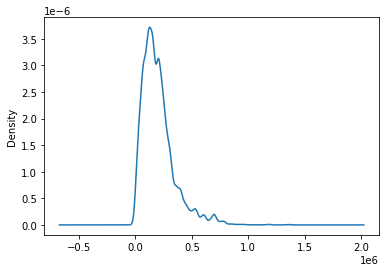

In [133]:
# Calculate levels of income for various Income Quartiles

top_10 = final_q['Average Income'].quantile(0.9)
print("Top 10%", top_10)

top_25 = final['Average Income'].quantile(0.75)
print("Top 25%", top_25)

top_50 = final['Average Income'].quantile(0.5)
print("Top 50%", top_50)

top_75 = final['Average Income'].quantile(0.25)
print("Top 75%", top_75)

top_90 = final['Average Income'].quantile(0.1)
print("Top 90%", top_90)

# Plot distribution of Average Income
final['Average Income'].plot(kind='kde')

# Add a column with quartile labels (and the top 10%)

In [134]:
# Add column to df based on Average Income quartile (and top 10%)

# Set conditions based on Average Income column
col = 'Average Income'
conditions = [final_q[col]>=top_10,
              (final_q[col]<top_10)&(final[col]>=top_25),
              (final_q[col]<top_25)&(final[col]>=top_50),
             (final_q[col]<top_50)&(final[col]>=top_75),
            final_q[col]<top_75]

# Create names for conditions
choices = ['top 10 pct', "top quartile", "second quartile", 'third quartile','fourth quartile']

# Create quartile column
final_q['quartile level'] = np.select(conditions,choices, default=np.nan)

# Review df
final_q.head()

,id,athleteId,recruitType,year,ranking,name,school,committedTo,position,height,...,hometownInfo.fipsCode,lat_adj,lng_adj,primary_city,state,adj_lat,adj_lng,Average Income,income_level,quartile level
0,19571,-1032080,HighSchool,2011,1.0,Jadeveon Clowney,South Pointe,South Carolina,WDE,77.0,...,45091,34.0,-81.0,Rock Hill,SC,34.0,-81.0,269076.0,high,top quartile
1,20160,512424,HighSchool,2011,591.0,Justin Worley,Northwestern,Tennessee,PRO,76.0,...,45091,34.0,-81.0,Rock Hill,SC,34.0,-81.0,269076.0,high,top quartile
2,20244,-1007350,HighSchool,2011,676.0,Roderick Byers,Northwestern,Clemson,SDE,75.0,...,45091,34.0,-81.0,Rock Hill,SC,34.0,-81.0,269076.0,high,top quartile
3,20875,-1032025,HighSchool,2011,1345.0,Gerald Dixon Jr.,Northwestern,South Carolina,DT,74.0,...,45091,34.0,-81.0,Rock Hill,SC,34.0,-81.0,269076.0,high,top quartile
4,21202,-1032025,HighSchool,2011,1672.0,Gerald Dixon,South Pointe,South Carolina,SDE,74.0,...,45091,34.0,-81.0,Rock Hill,SC,34.0,-81.0,269076.0,high,top quartile


In [135]:
# Review distribution of final rating col
final_q['rating'].describe()

count    43003.000000
mean         0.822681
std          0.057294
min          0.615400
25%          0.779700
50%          0.820400
75%          0.856500
max          1.000000
Name: rating, dtype: float64

# On average, how many prospects fall into each star rating category?

In [136]:
# Calculate Total and Average prospects per year by star ranking

# Get total counts for each star level
yearly = final_q.groupby(['year','stars'])['id'].count()

# Convert into df
yearly_df = pd.DataFrame(yearly)

# Review yearly totals
yearly_df.tail(15)

# Calculate average number of prospects per year for each star ranking
yr_avg = pd.DataFrame(yearly_df.groupby(['stars'])['id'].mean().round(0))

# Calculate average total number of prospects per year
print('Average total prospects per year',yr_avg.sum())

# Show averages by star ranking
yr_avg

Average total prospects per year id    3324.0
dtype: float64


,id
stars,
1,74.0
2,1115.0
3,1775.0
4,328.0
5,32.0


In [137]:
# Check counts for a given year

# Subset df based on chosen year
single_year = final_q[final_q['year']==2022]

# Get number of entries
print(len(single_year))

# Review how many players are included for each star rating
single_year['stars'].value_counts()

2130


3    1616
4     387
2      92
5      35
Name: stars, dtype: int64

# Given a particular quartile, is the average income different for each star rating?

In [138]:
# Average Income by star rating based on quartiles

# Groupby quartiles and stars, get mean income
stars_v_income = np.round(pd.DataFrame(final_q.groupby(['quartile level','stars'])['Average Income'].mean()).unstack('stars').divide(1000))

# Get rid of multi index
stars_v_income.columns = stars_v_income.columns.get_level_values(1)

# Sort in descending order
stars_v_income.sort_values(by=1,ascending=False,inplace=True)

# Reverse order of columns so 5 star is first
stars_v_income.iloc[:,::-1]
#stars_v_income

stars,5,4,3,2,1
quartile level,,,,,
top 10 pct,532.0,537.0,532.0,532.0,514.0
top quartile,301.0,306.0,306.0,307.0,308.0
second quartile,212.0,213.0,213.0,212.0,211.0
third quartile,134.0,136.0,136.0,137.0,135.0
fourth quartile,66.0,61.0,60.0,59.0,62.0


# How many 5, 4 and 3-star recruits are there by position group?

In [139]:
# Create position group mapping

position_map = {'QB':'Quarterback','DUAL':'Quarterback','PRO':'Quarterback',
                'RB':'Running Back','FB':'Running Back','APB':'Running Back',
                'WR':'Wide Receiver','TE':'Wide Receiver',
                'IOL':'Offensive Line','OC':'Offensive Line','OG':'Offensive Line','OT':'Offensive Line',
                'EDGE':'Def Line','DL':'Def Line','WDE':'Def Line','SDE':'Def Line','DT':"Def Line",
                'LB':'Linebacker','ILB':'Linebacker','OLB':'Linebacker',
                'S':'Cornerback','CB':'Cornerback'
               }

In [140]:
# Map position groups dictionary to 'position' column and create new 'mapped position' column

# Create copy of df
df_mapped_positions = final_q.copy()

# Map position group names to position column
df_mapped_positions['mapped_position'] = df_mapped_positions['position'].map(position_map)
#df_mapped_positions.head()

# 5-star recruits ------------------------------------------

# Get subset of data for only 5-star recruits
stars_5 = df_mapped_positions[df_mapped_positions['stars']==5]
print("Total 5 star Recruits (all positions): ",len(stars_5))

# Get counts by position
position_5 = stars_5.groupby('mapped_position')['mapped_position'].count()
#position_5

# 4-star recruits ------------------------------------------

# Get subset of data for only 4-star recruits
stars_4 = df_mapped_positions[df_mapped_positions['stars']==4]
print("Total 4 star Recruits (all positions): ",len(stars_4))

# Get counts by position
position_4 = stars_4.groupby('mapped_position')['mapped_position'].agg('count')
#position_4

# 3-star recruits ------------------------------------------

# Get subset of data for only 3-star recruits
stars_3 = df_mapped_positions[df_mapped_positions['stars']==3]
print("Total 3 star Recruits (all positions): ",len(stars_3))

# Get counts by position
position_3 = stars_3.groupby('mapped_position')['mapped_position'].count()
#position_3

# Combine 5, 4 and 3 star data ------------------------------

all_ranking = pd.DataFrame([position_5,position_4,
                                 position_3])

# Transpose to get star rankings as columns
all_rankings_T = all_ranking.T

# Add column names
all_rankings_T.columns = ['Total 5 star','Total 4 star','Total 3 star']
all_rankings_T.reset_index(inplace=True)

# Show data
all_rankings_T

Total 5 star Recruits (all positions):  422
Total 4 star Recruits (all positions):  4261
Total 3 star Recruits (all positions):  23077


,mapped_position,Total 5 star,Total 4 star,Total 3 star
0,Cornerback,63,694,3763
1,Def Line,110,779,3671
2,Linebacker,43,469,2543
3,Offensive Line,55,635,3579
4,Quarterback,36,297,1432
5,Running Back,44,337,1847
6,Wide Receiver,50,791,4082


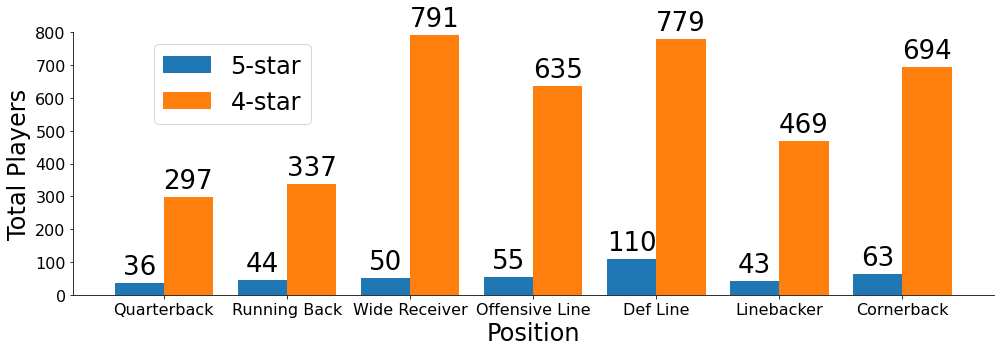

In [141]:
# Create bar chart for numbers of 5 and 4 star prospects


# Create ordered list of position labels for x-axis
labels = ['Quarterback','Running Back','Wide Receiver','Offensive Line','Def Line','Linebacker','Cornerback']

# Copy all_rankings_T df
bar_chart_df = all_rankings_T.copy()

# Create mapping based on order of labels
bar_chart_df['mapped_position'] = pd.Categorical(bar_chart_df['mapped_position'],categories=labels)

# Sort df by ordered labels
bar_chart_df.sort_values(by='mapped_position',inplace=True)
#bar_chart_df

# Create plot
fig, ax = plt.subplots(figsize=(14,5))

# Create list of labels for x-axis
x = np.arange(len(labels))

# Set width of bars
width = 0.4

# Create 5 and 4 star bars separately
rects1 = ax.bar(x - width/2,bar_chart_df['Total 5 star'],width,label='5-star')
rects2 = ax.bar(x + width/2,bar_chart_df['Total 4 star'],width,label='4-star')

# Format chart
ax.set_ylabel('Total Players',fontsize=24)
ax.set_xlabel('Position',fontsize=24)
ax.set_ylim(0,800)

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_xlabel('Position', fontsize=24)
ax.tick_params(labelsize=16)


# Create legend
ax.legend(loc='best',bbox_to_anchor=(0.075, 0.25, 0.75, 0.75),fontsize=24)

# Remove lines at top and right of chart
ax.spines[['right', 'top']].set_visible(False)

# Add values above bars
ax.bar_label(rects1, padding=3,fontsize=26)
ax.bar_label(rects2, padding=3,fontsize=26)

fig.tight_layout()

# Save chart to png file
plt.savefig('5&4 grouped bar.png')

# Show plot
plt.show()

# Calculate total number of recruits from each state

In [142]:
# Groupby state -- how many 5/4/3 star recruits from each state?

# Groupby to get counts by state
state = final_q.groupby(['state','stars'])['stars'].count()
print(len(final_q))

# Turn into df
state_df = pd.DataFrame(state)

# Rename columns
state_df = state_df.rename(columns={'stars':'total players'})

# Reset index
state_df.reset_index('stars',inplace=True)

# Review df
#state_df.head(5)

# Pivot df so star ratings become columns
state_pivot = state_df.pivot(columns='stars')

# Flatten df
state_pivot.columns = state_pivot.columns.get_level_values(1)

# Add sum of each state
state_pivot['total recruits'] = state_pivot.sum(axis=1)

# Sort by total number of recruits
most_stars = state_pivot.sort_values(by='total recruits',ascending=False)

# Reset index
most_stars.reset_index(inplace=True)

# Calculate each state's % of total recruits
most_stars['% of total recruits'] = (most_stars['total recruits']/sum(most_stars['total recruits'])).multiply(100).round(1)

# Calculate % of each state's recruits that are 5 star
most_stars['5 % of total'] = (most_stars[5] / most_stars['total recruits']).multiply(100).round(2)

# Show table
most_stars.head()

43003


stars,state,1,2,3,4,5,total recruits,% of total recruits,5 % of total
0,TX,45.0,1839.0,3235.0,600.0,63.0,5782.0,13.4,1.09
1,FL,93.0,1666.0,3198.0,597.0,81.0,5635.0,13.1,1.44
2,CA,66.0,1466.0,2275.0,449.0,44.0,4300.0,10.0,1.02
3,GA,59.0,925.0,1987.0,384.0,47.0,3402.0,7.9,1.38
4,OH,13.0,656.0,1026.0,173.0,12.0,1880.0,4.4,0.64


# Check at individual position level (rather than position group level) whether there are any trends showing that average income is significantly higher for higher star ratings.

In [143]:
# Part A: Count total number of 5, 4, 3 star prospects for each individual position

# 5 star recruits ------------------------------------------------------

# Take subset of df for only 5-star propsects
x_stars_5 = final_q[final_q['stars']==5]
print("Total 5 star Recruits (all positions): ",len(x_stars_5))

# Groupby position and count
position_totals_5 = x_stars_5.groupby('position')['position'].count()


# 4 star recruits ------------------------------------------------------

# Take subset of df for only 4-star propsects
x_stars_4 = final_q[final_q['stars']==4]
print("Total 4 star Recruits (all positions): ",len(x_stars_4))

# Groupby position and count
position_totals_4 = x_stars_4.groupby('position')['position'].agg('count')


# 3 star recruits ------------------------------------------------------

# Take subset of df for only 3-star propsects
x_stars_3 = final_q[final_q['stars']==3]
print("Total 3 star Recruits (all positions): ",len(x_stars_3))

# Groupby position and count
position_totals_3 = x_stars_3.groupby('position')['position'].count()


# Combine 5, 4 and 3 star data-------------------------------------------------- 
all_star_ranking = pd.DataFrame([position_totals_5,position_totals_4,
                                 position_totals_3])

# Transpose to get star rankings in columns
all_star_rankings_T = all_star_ranking.T

# Add column names
all_star_rankings_T.columns = ['Total 5 star','Total 4 star','Total 3 star']

# Show results
all_star_rankings_T.head()

Total 5 star Recruits (all positions):  422
Total 4 star Recruits (all positions):  4261
Total 3 star Recruits (all positions):  23077


,Total 5 star,Total 4 star,Total 3 star
APB,7.0,74.0,287.0
ATH,21.0,259.0,1874.0
CB,39.0,377.0,1966.0
DL,12.0,99.0,346.0
DT,38.0,252.0,1170.0


In [144]:
# Spot check 5-star, PRO quarterbacks

# Take subset of all PRO-style QBs
only_qb = final_q[final_q['position']=='PRO']

# Get 5-star PRO qbs only
five_qb = only_qb[only_qb['stars']==5]

# Review list
five_qb.head()

,id,athleteId,recruitType,year,ranking,name,school,committedTo,position,height,...,hometownInfo.fipsCode,lat_adj,lng_adj,primary_city,state,adj_lat,adj_lng,Average Income,income_level,quartile level
2661,24967,546415,HighSchool,2013,11.0,Max Browne,Skyline,USC,PRO,77.0,...,53033,47.0,-122.0,Sammamish,WA,47.0,-122.0,504884.0,high,top 10 pct
4792,35187,4035292,HighSchool,2016,4.0,Shea Patterson,IMG Academy,Ole Miss,PRO,73.5,...,12081,27.0,-82.0,Bradenton,FL,27.0,-82.0,179001.0,high,second quartile
6100,42923,4374303,HighSchool,2018,16.0,JT Daniels,Mater Dei,USC,PRO,74.0,...,06059,33.0,-117.0,Santa Ana,CA,33.0,-117.0,244681.0,high,second quartile
7135,28218,559681,HighSchool,2014,8.0,Kyle Allen,Desert Mountain,Texas A&M,PRO,75.0,...,04013,33.0,-111.0,Scottsdale,AZ,33.0,-111.0,365571.0,high,top quartile
13797,71482,4433971,HighSchool,2021,27.0,Kyle McCord,St. Joseph's,Ohio State,PRO,75.0,...,42101,39.0,-75.0,Philadelphia,PA,39.0,-75.0,163429.0,high,third quartile


In [145]:
# Part B -- Calculate average income by star ranking

# 5 star----------------------------------------------------

# Get subset of 5-star recruits
x_stars_5 = final_q[final_q['stars']==5]

# Group by position, get mean Average Income
position_income_5_mean = (pd.DataFrame(x_stars_5.groupby(['position'])['Average Income'].mean().divide(1000))).round(2)

# Rename column
position_income_5_mean.columns = ['5 star mean inc']
#position_income_5_mean

# 4 star----------------------------------------------------

# Get subset of 4-star recruits
x_stars_4 = final_q[final_q['stars']==4]

# Group by position, get mean Average Income
position_income_4_mean = (pd.DataFrame(x_stars_4.groupby(['position'])['Average Income'].mean().divide(1000))).round(2)

# Rename column
position_income_4_mean.columns = ['4 star mean inc']
#position_income_4_mean

# 3 star----------------------------------------------------

# Get subset of 3-star recruits
x_stars_3 = final_q[final_q['stars']==3]

# Group by position, get mean Average Income
position_income_3_mean = (pd.DataFrame(x_stars_3.groupby(['position'])['Average Income'].mean().divide(1000))).round(2)

# Rename column
position_income_3_mean.columns = ['3 star mean inc']
#position_income_3_mean

# Combine 5,4 and 3 star rankings --------------------------

# Combine data for 5, 4 and 4 star rankings
position_avg_inc_all = pd.concat([position_income_5_mean,position_income_4_mean,position_income_3_mean],axis=1)

# Calculate % change between Average Income of 5 star v 4 star, and 4 star v 3 star
position_avg_inc_all['5 v 4'] = (position_avg_inc_all['5 star mean inc'] / position_avg_inc_all['4 star mean inc']-1).round(2)
position_avg_inc_all['4 v 3'] = (position_avg_inc_all['4 star mean inc'] / position_avg_inc_all['3 star mean inc']-1).round(2)

# Review data                          
position_avg_inc_all.head()

,5 star mean inc,4 star mean inc,3 star mean inc,5 v 4,4 v 3
APB,275.43,209.24,209.70,0.32,-0.00
ATH,161.25,181.62,176.83,-0.11,0.03
CB,226.70,213.01,202.07,0.06,0.05
DL,244.80,197.94,203.73,0.24,-0.03
DT,160.35,180.49,191.38,-0.11,-0.06


In [146]:
# Part C Combine Results -- total number of 5,4,3 star prospects AND mean income 
# for each position, plus % changes btw 5 and 4-star avg inc and 4 and 3-star avg inc

# Combine df from Part A (# of recruits) with Part B (Avg Inc)
player_avg_inc = pd.concat([all_star_rankings_T,position_avg_inc_all],axis=1)

# Sort df by 4-star mean income
player_avg_inc.sort_values(by='4 star mean inc',ascending=False)

# Review first few items
player_avg_inc.head()

,Total 5 star,Total 4 star,Total 3 star,5 star mean inc,4 star mean inc,3 star mean inc,5 v 4,4 v 3
APB,7.0,74.0,287.0,275.43,209.24,209.70,0.32,-0.00
ATH,21.0,259.0,1874.0,161.25,181.62,176.83,-0.11,0.03
CB,39.0,377.0,1966.0,226.70,213.01,202.07,0.06,0.05
DL,12.0,99.0,346.0,244.80,197.94,203.73,0.24,-0.03
DT,38.0,252.0,1170.0,160.35,180.49,191.38,-0.11,-0.06


# Aggregate level analysis -- Check distribution of recruits across each star rating and income quartile

In [147]:
# Aggregate level data -- all positions

# Group by quintiles and stars, then get counts
all_positions = (pd.DataFrame(final_q.groupby(['stars','quartile level'])['quartile level'].count()))

# Add % of each subgroup column
all_positions['Pct'] = (all_positions['quartile level'] / \
all_positions.groupby('stars')['quartile level'].transform('sum')).round(2)

# Show only 5 and 4 star recruit data
all_positions.tail(10)

quartile level   Pct
stars quartile level                       
4     fourth quartile             991  0.23
      second quartile            1079  0.25
      third quartile             1061  0.25
      top 10 pct                  469  0.11
      top quartile                661  0.16
5     fourth quartile             100  0.24
      second quartile             114  0.27
      third quartile              108  0.26
      top 10 pct                   43  0.10
      top quartile                 57  0.14

# Calculate same breakdown of star rankings and income quartiles at position group level

Create function to calculate number of recruits at each star level and income bracket.    Also calculate what % of recruits are from a particular income quartile for a given star level.

In [148]:
def star_quartile_by_position(indf,indiv_positions):

    # Filter by position
    position_df = indf[indf['position'].isin(indiv_positions)]
    print("Total number in position group:",len(position_df))

    # Show value counts by star ranking for reference
    print(position_df['stars'].value_counts())

    # Groupby quartiles and stars, get counts of number of recruits in each combination of star & quartile
    position_quartiles_stars = (pd.DataFrame(position_df.groupby(['stars','quartile level'])['quartile level'].count()))

    # Add column to show % of recruits from each income quartile within each star level
    position_quartiles_stars['Pct'] = (position_quartiles_stars['quartile level'] / \
    position_quartiles_stars.groupby('stars')['quartile level'].transform('sum')).round(2)

    return position_quartiles_stars

# Offensive Position Groups

In [149]:
# Get value counts by star ranking, totals in each income quartile and % for QB
qb_stars_quartiles = star_quartile_by_position(final_q,['QB','DUAL','PRO'])

# Show 5 and 4-star data only
qb_stars_quartiles[-10:]

Total number in position group: 2802
3    1432
2     977
4     297
1      60
5      36
Name: stars, dtype: int64


quartile level   Pct
stars quartile level                       
4     fourth quartile              54  0.18
      second quartile              61  0.21
      third quartile               71  0.24
      top 10 pct                   53  0.18
      top quartile                 58  0.20
5     fourth quartile               6  0.17
      second quartile               9  0.25
      third quartile                7  0.19
      top 10 pct                    5  0.14
      top quartile                  9  0.25

# Tests of Statistical Significance

# T-Test --- is distribution of QB data significantly different from the rest of the data?

# Create function to run t-test for a given position group

In [150]:
def t_test_calc(indf,indiv_positions):
    
    # Calc mean Average Income for all players at chosen position
    avg_inc_for_position = indf['Average Income'].mean()
    print("Average Income for Position: ", avg_inc_for_position)

    # Make copy of final_q df
    final_q_copy = final_q.copy()

    # Exclude all players at chosen position from broader df
    exclude_position_df = final_q_copy[~final_q_copy['position'].isin(indiv_positions)]

    # Calc mean of avg inc for all remaining prospects
    exclude_position_avg_inc = exclude_position_df['Average Income'].mean()
    print("All Mean: ", exclude_position_avg_inc)

    # Use t-test to see if means are equal (Ho) 
    
    # Import ttest
    from scipy.stats import ttest_rel, ttest_ind
    
    # Calculate test stat and p-value
    stat,p = ttest_ind(indf['Average Income'],exclude_position_df['Average Income'])
    print("T-stat",stat,"p-value",p)

    # Interpretation
    alpha = 0.05

    if p > alpha:
        print("Same distributions (fail to reject Ho)")
    else:
        print("Different dist (reject Ho)")


In [151]:
# Create subset of only QBs
all_qb_df = final_q[final_q['position'].isin(['QB','DUAL','PRO'])]

# Review df
all_qb_df.head()

# Get length of df
print(len(all_qb_df))

2802


In [152]:
# Run t-test for Quarterbacks
qb_ttest = t_test_calc(all_qb_df,['QB','DUAL','PRO'])
qb_ttest

Average Income for Position:  220121.10492505354
All Mean:  200568.96413024553
T-stat 6.847424546992484 p-value 7.619895128099995e-12
Different dist (reject Ho)


In [153]:
# Also test using Mann-Whitney U test -- More suitable for non-normally distributed data

from scipy.stats import mannwhitneyu

def mann_whitney_calc(indf,indiv_positions):
    
    # Calculate mean Average Income for all players at chosen position
    avg_inc_for_position = indf['Average Income'].mean()
    print("Average Income for Position: ", avg_inc_for_position)

    # Make copy of final_q df
    final_q_copy = final_q.copy()

    # Exclude all players at chosen position from broader df
    exclude_position_df = final_q_copy[~final_q_copy['position'].isin(indiv_positions)]

    # Calc mean of Average Income for all remaining prospects
    exclude_position_avg_inc = exclude_position_df['Average Income'].mean()
    print("All Mean: ", exclude_position_avg_inc)

    # Use t-test to see if means are equal (Ho) 

    # Import ttest
    from scipy.stats import ttest_rel, ttest_ind
    
    # Calculate test stat and p value
    stat,p = mannwhitneyu(indf['Average Income'],exclude_position_df['Average Income'])
    print("Mann-Whitney Stat",stat,"p-value",p)

    # Interpretation
    alpha = 0.05

    if p > alpha:
        print("Same distributions (fail to reject Ho)")
    else:
        print("Different dist (reject Ho)")

In [154]:
# Run t-test for Quarterbacks
qb_mann = mann_whitney_calc(all_qb_df,['QB','DUAL','PRO'])
qb_mann

Average Income for Position:  220121.10492505354
All Mean:  200568.96413024553
Mann-Whitney Stat 60288405.5 p-value 4.2791435953507994e-10
Different dist (reject Ho)


# Confirm graphically whether the distribution of income for QBs looks different compared to all other recruits

In [155]:
def inc_dist_comparison(indf,indiv_positions):
    
    # Get subset of players at chosen position
    position_subset_df = indf[indf['position'].isin(indiv_positions)]
    
    # Make copy of final_q df
    final_q_copy = final_q.copy()

    # Exclude all players at chosen position from broader df
    all_other_positions_df = final_q_copy[~final_q_copy['position'].isin(indiv_positions)]
    
    # Create chart
    
    # Create figure
    fig,ax = plt.subplots(figsize=(15,5))

    # Income Distribution of all players EXCLUDING chosen position
    all_other_position_inc_dist = all_other_positions_df['Average Income'].plot(kind='kde',ax=ax,linewidth=5,color='blue')

    # Set up second axis
    ax2 = ax.twinx()

    # Income Distibution for chosen position
    position_inc_dist = position_subset_df['Average Income'].plot(kind='kde',ax=ax2,ls='--',color='red',linewidth=3)

    # Format chart and show
    plt.legend(loc='upper right')
    fig.tight_layout()
    plt.show()

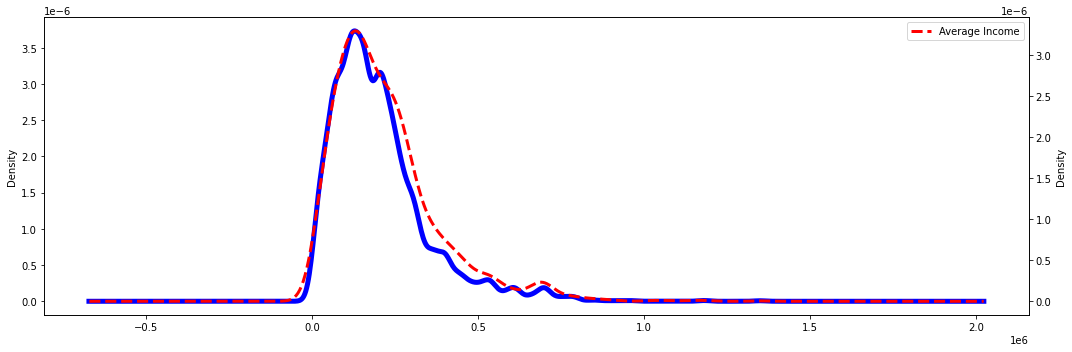

In [156]:
# Compare distribution of income for Quarterbacks vs all other players
qb_inc_chart = inc_dist_comparison(final_q,['QB','PRO','DUAL'])

In [157]:
# Get value counts by star ranking, totals in each income quartile and % for Running Backs
rb_stars_quartiles = star_quartile_by_position(final_q,['RB','FB','APB'])

# Show 5 and 4 star data
rb_stars_quartiles[-10:]

Total number in position group: 3542
3    1847
2    1223
4     337
1      91
5      44
Name: stars, dtype: int64


quartile level   Pct
stars quartile level                       
4     fourth quartile              93  0.28
      second quartile              82  0.24
      third quartile               83  0.25
      top 10 pct                   28  0.08
      top quartile                 51  0.15
5     fourth quartile              12  0.27
      second quartile              11  0.25
      third quartile               11  0.25
      top 10 pct                    4  0.09
      top quartile                  6  0.14

In [158]:
# Create subset of only RBs
all_rb_df = final_q[final_q['position'].isin(['RB','FB','APB'])]

# Review df
all_rb_df.head()

# Get length of df
print(len(all_rb_df))

3542


In [159]:
# Calculate t-test for Running Backs
rb_ttest = t_test_calc(all_rb_df,['RB','FB','APB'])
rb_ttest

Average Income for Position:  193264.86645962732
All Mean:  202612.91163427182
T-stat -3.6453566263338204 p-value 0.0002673358175786091
Different dist (reject Ho)


In [160]:
# Calculate Mann-Whitney U test for Running Backs
rb_mann = mann_whitney_calc(all_rb_df,['RB','FB','APB'])
rb_mann

Average Income for Position:  193264.86645962732
All Mean:  202612.91163427182
Mann-Whitney Stat 67001610.0 p-value 4.6067354258201134e-05
Different dist (reject Ho)


In [161]:
# Get value counts by star ranking, totals in each income quartile and % for Wide Receivers
wr_stars_quartiles = star_quartile_by_position(final_q,['WR','TE'])
 
# Show results for 5 and 4 star recruits only
wr_stars_quartiles[-10:]

Total number in position group: 7479
3    4082
2    2453
4     791
1     103
5      50
Name: stars, dtype: int64


quartile level   Pct
stars quartile level                       
4     fourth quartile             165  0.21
      second quartile             232  0.29
      third quartile              173  0.22
      top 10 pct                   89  0.11
      top quartile                132  0.17
5     fourth quartile              11  0.22
      second quartile              13  0.26
      third quartile               14  0.28
      top 10 pct                    4  0.08
      top quartile                  8  0.16

In [162]:
# Create subset of only Wide Receivers
all_wr_df = final_q[final_q['position'].isin(['WR','TE'])]

# Review df
all_wr_df.head()

# Get length of df
print(len(all_wr_df))

7479


In [163]:
# Calculate t-test for Wide Receivers
wr_ttest = t_test_calc(all_wr_df,['WR','TE'])
wr_ttest

Average Income for Position:  205965.9649685787
All Mean:  200974.91304470217
T-stat 2.6832117183540394 p-value 0.00729467053331541
Different dist (reject Ho)


In [164]:
# Calculate Mann-Whitney U test for Wide Receivers
wr_mann = mann_whitney_calc(all_wr_df,['WR','TE'])
wr_mann

Average Income for Position:  205965.9649685787
All Mean:  200974.91304470217
Mann-Whitney Stat 135920713.0 p-value 0.0016039218825468964
Different dist (reject Ho)


In [165]:
# Get value counts by star ranking, totals in each income quartile and % for Offensive Linemen
ol_stars_quartiles = star_quartile_by_position(final_q,['IOL','OC','OG','OT'])

# Show results for 5 and 4 star recruits only
ol_stars_quartiles[-10:]

Total number in position group: 6621
3    3579
2    2236
4     635
1     116
5      55
Name: stars, dtype: int64


quartile level   Pct
stars quartile level                       
4     fourth quartile             142  0.22
      second quartile             149  0.23
      third quartile              150  0.24
      top 10 pct                   82  0.13
      top quartile                112  0.18
5     fourth quartile               8  0.15
      second quartile              14  0.25
      third quartile               13  0.24
      top 10 pct                    9  0.16
      top quartile                 11  0.20

In [166]:
# Create subset of only Offensive Linemen
all_ol_df = final_q[final_q['position'].isin(['IOL','OC','OG','OT'])]

# Review df
all_ol_df.head()

# Get length of df
print(len(all_ol_df))

6621


In [167]:
# Calculate t-test for Offensive Linemen
ol_ttest = t_test_calc(all_ol_df,['IOL','OC','OG','OT'])
ol_ttest

Average Income for Position:  207611.67301011932
All Mean:  200793.1223132318
T-stat 3.49061922161481 p-value 0.0004823852604298276
Different dist (reject Ho)


In [168]:
# Calculate Mann-Whitney U test for Offensive Linemen
ol_mann = mann_whitney_calc(all_ol_df,['IOL','OC','OG','OT'])
ol_mann

Average Income for Position:  207611.67301011932
All Mean:  200793.1223132318
Mann-Whitney Stat 122014768.5 p-value 0.09062396430508905
Same distributions (fail to reject Ho)


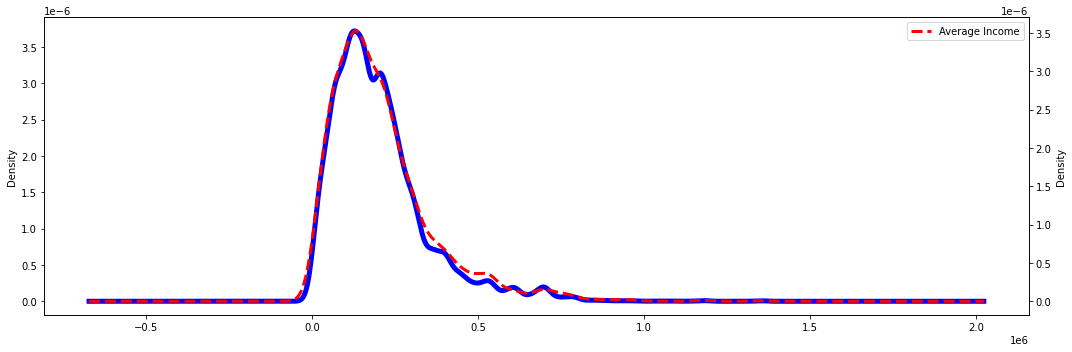

In [169]:
# Compare distribution of income for Offensive Linemen vs all other players
ol_inc_chart = inc_dist_comparison(final_q,['IOL','OC','OG','OT'])

In [170]:
# Combine all offensive position groups - QB, RB, WR and OL

# Combine results from QB, RB, WR and OL analysis
combined_positions_off = pd.concat([qb_stars_quartiles,rb_stars_quartiles,wr_stars_quartiles,ol_stars_quartiles],axis=1)

# Add column names
combined_positions_off.columns = ['QB Total','QB %','RB Total','RB %','WR Total','WR %','OL Total','OL %']

# Show only 5 and 4 star data
combined_positions_off.tail(10)

QB Total  QB %  RB Total  RB %  WR Total  WR %  \
stars quartile level                                                    
4     fourth quartile        54  0.18        93  0.28       165  0.21   
      second quartile        61  0.21        82  0.24       232  0.29   
      third quartile         71  0.24        83  0.25       173  0.22   
      top 10 pct             53  0.18        28  0.08        89  0.11   
      top quartile           58  0.20        51  0.15       132  0.17   
5     fourth quartile         6  0.17        12  0.27        11  0.22   
      second quartile         9  0.25        11  0.25        13  0.26   
      third quartile          7  0.19        11  0.25        14  0.28   
      top 10 pct              5  0.14         4  0.09         4  0.08   
      top quartile            9  0.25         6  0.14         8  0.16   

                       OL Total  OL %  
stars quartile level                   
4     fourth quartile       142  0.22  
      second quartile       149  0.23  
      third quartile        150  0.24  
      top 10 pct             82  0.13  
      top quartile          112  0.18  
5     fourth quartile         8  0.15  
      second quartile        14  0.25  
      third quartile         13  0.24  
      top 10 pct              9  0.16  
      top quartile           11  0.20

# Defensive position groups

In [171]:
# Get value counts by star ranking, totals in each income quartile and % for Defensive Linemen
dl_stars_quartiles = star_quartile_by_position(final_q,['EDGE','DL','WDE','SDE','DT'])
#dl_stars_quartiles

Total number in position group: 6660
3    3671
2    2035
4     779
5     110
1      65
Name: stars, dtype: int64


In [172]:
# Create subset of only Defensive Linemen
all_dl_df = final_q[final_q['position'].isin(['EDGE','DL','WDE','SDE','DT'])]

# Review df
all_dl_df.head()

# Get length of df
print(len(all_dl_df))

6660


In [173]:
# Calculate t-test for Defensive Linemen
dl_ttest = t_test_calc(all_dl_df,['EDGE','DL','WDE','SDE','DT'])
dl_ttest

Average Income for Position:  196290.76471471472
All Mean:  202860.4069559475
T-stat -3.371245732534005 p-value 0.0007489493109277383
Different dist (reject Ho)


In [174]:
# Calculate Mann-Whitney U tset for Defensive Linemen
dl_mann = mann_whitney_calc(all_dl_df,['EDGE','DL','WDE','SDE','DT'])
dl_mann

Average Income for Position:  196290.76471471472
All Mean:  202860.4069559475
Mann-Whitney Stat 117272051.0 p-value 5.658812852002321e-05
Different dist (reject Ho)


In [175]:
# Get value counts by star ranking, totals in each income quartile and % for Linebackers
lb_stars_quartiles = star_quartile_by_position(final_q,['LB','ILB','OLB'])
#lb_stars_quartiles

Total number in position group: 4938
3    2543
2    1822
4     469
1      61
5      43
Name: stars, dtype: int64


In [176]:
# Create subset of only Linebackers
all_lb_df = final_q[final_q['position'].isin(['LB','ILB','OLB'])]

# Review df
all_lb_df.head()

# Get length of df
print(len(all_lb_df))

4938


In [177]:
# Calculate t-test for Linebackers
lb_ttest = t_test_calc(all_lb_df,['LB','ILB','OLB'])
lb_ttest

Average Income for Position:  204613.72600243014
All Mean:  201483.50673847366
T-stat 1.4153607191798185 p-value 0.1569700025232432
Same distributions (fail to reject Ho)


In [178]:
# Calculate Mann-Whitney U test for Linebackers
lb_mann = mann_whitney_calc(all_lb_df,['LB','ILB','OLB'])
lb_mann

Average Income for Position:  204613.72600243014
All Mean:  201483.50673847366
Mann-Whitney Stat 95479088.0 p-value 0.06822681192992668
Same distributions (fail to reject Ho)


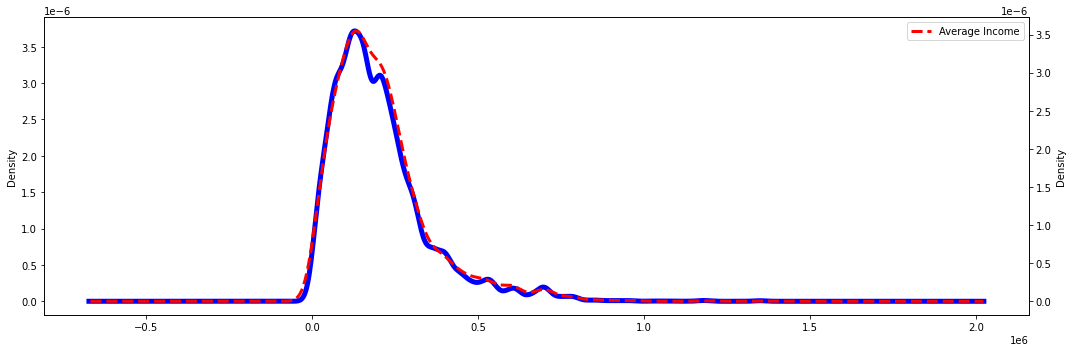

In [179]:
# Compare distribution of income for Linebackers vs all other players
lb_inc_chart = inc_dist_comparison(final_q,['LB','ILB','OLB'])

In [180]:
# Get value counts by star ranking, totals in each income quartile and % for Cornerbacks
cb_stars_quartiles = star_quartile_by_position(final_q,['S','CB'])

# Show results for 5 and 4-star recruits only
#cb_stars_quartiles[-10:]

Total number in position group: 6867
3    3763
2    2267
4     694
1      80
5      63
Name: stars, dtype: int64


In [181]:
# Create subset of only Cornerbacks
all_cb_df = final_q[final_q['position'].isin(['S','CB'])]

# Review df
all_cb_df.head()

# Get length of df
print(len(all_cb_df))

6867


In [182]:
# Calculate t-test for Cornerbacks
cb_ttest = t_test_calc(all_cb_df,['S','CB'])
cb_ttest

Average Income for Position:  201018.1508664628
All Mean:  201999.6851062652
T-stat -0.5099224496921401 p-value 0.6101084104475084
Same distributions (fail to reject Ho)


In [183]:
# Calculate Mann-Whitney U test for Cornerbacks
cb_mann = mann_whitney_calc(all_cb_df,['S','CB'])
cb_mann

Average Income for Position:  201018.1508664628
All Mean:  201999.6851062652
Mann-Whitney Stat 126676193.0 p-value 0.005770008294557961
Different dist (reject Ho)


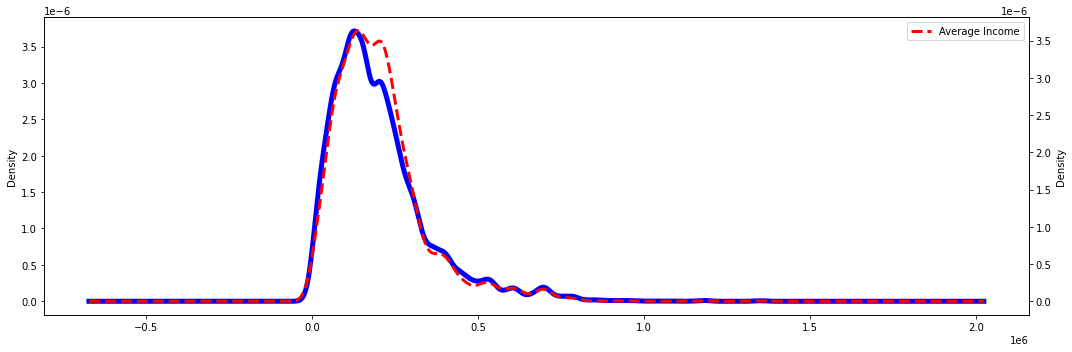

In [184]:
# Compare distribution of income for Cornerbacks vs all other players
cb_inc_chart = inc_dist_comparison(final_q,['S','CB'])

In [185]:
# Combine all defensive position groups

# Combine results from DL, LB and CB analysis
combined_positions_def = pd.concat([dl_stars_quartiles,lb_stars_quartiles,cb_stars_quartiles],axis=1)

# Add column names
combined_positions_def.columns = ['DL Total','DL %','LB Total','LB %','CB Total','CB %']

# Show only 5 and 4 star data
combined_positions_def.tail(10)

DL Total  DL %  LB Total  LB %  CB Total  CB %
stars quartile level                                                 
4     fourth quartile       202  0.26       108  0.23       152  0.22
      second quartile       188  0.24       120  0.26       187  0.27
      third quartile        210  0.27       127  0.27       177  0.26
      top 10 pct             75  0.10        51  0.11        75  0.11
      top quartile          104  0.13        63  0.13       103  0.15
5     fourth quartile        33  0.30        12  0.28        12  0.19
      second quartile        29  0.26        12  0.28        20  0.32
      third quartile         28  0.25        12  0.28        17  0.27
      top 10 pct             10  0.09         5  0.12         6  0.10
      top quartile           10  0.09         2  0.05         8  0.13

# Analyze income distribution by individual colleges or conferences

# Create function to analyze any single college's recruits

In [186]:
def indiv_college_analyzer(indf,college):

    # Filter by school
    school_x = indf[indf['committedTo']==college]
    
    # Show how many recruits chosen college has in total
    print("Total of recruits for chosen school: ",len(school_x))
    #school_x.head()

    # Show value counts by star ranking for reference
    print(school_x['stars'].value_counts())

    # Groupby quintiles and stars and get counts
    school_x_quintiles_stars = (pd.DataFrame(school_x.groupby(['stars','quartile level'])['quartile level'].count()))

    # Add % of each subgroup
    school_x_quintiles_stars['Pct'] = (school_x_quintiles_stars['quartile level'] / \
    school_x_quintiles_stars.groupby('stars')['quartile level'].transform('sum')).round(2)

    return school_x_quintiles_stars

In [187]:
# Calculate star / income quartile breakdown for an individual school
georgia = indiv_college_analyzer(final_q,'Georgia')

# Show only 5 and 4 star totals
georgia[-10:]

Total of recruits for chosen school:  313
4    163
3     98
5     47
2      5
Name: stars, dtype: int64


quartile level   Pct
stars quartile level                       
4     fourth quartile              47  0.29
      second quartile              50  0.31
      third quartile               35  0.21
      top 10 pct                    8  0.05
      top quartile                 23  0.14
5     fourth quartile              20  0.43
      second quartile              12  0.26
      third quartile                9  0.19
      top 10 pct                    2  0.04
      top quartile                  4  0.09

# Calculate more detailed breakdown at position rather then position group level

In [188]:
# Analyze a given school's recruits at position (not position group) level

school = 'Georgia'

# Filter by school
school_x = final_q[final_q['committedTo']==school]
print("len of school",len(school_x))
#school_x.head()

# Show value counts by star ranking
print(school_x['stars'].value_counts())

# Groupby quintiles and stars, get mean income
school_x_quintiles_stars = (pd.DataFrame(school_x.groupby(['stars','quartile level','position'])['quartile level'].count()))

# Add % of each subgroup
school_x_quintiles_stars['Pct'] = (school_x_quintiles_stars['quartile level'] / \
school_x_quintiles_stars.groupby('stars')['quartile level'].transform('sum')).round(2)

#school_x_quintiles_stars[-50:]

len of school 313
4    163
3     98
5     47
2      5
Name: stars, dtype: int64


In [189]:
# Calculate star / income quartile breakdown for an individual school
ucla = indiv_college_analyzer(final_q,'UCLA')

# Show only 5 and 4 star totals
ucla[-9:]

Total of recruits for chosen school:  257
3    150
4     81
2     17
5      8
1      1
Name: stars, dtype: int64


quartile level   Pct
stars quartile level                       
4     fourth quartile               6  0.07
      second quartile              22  0.27
      third quartile               12  0.15
      top 10 pct                   15  0.19
      top quartile                 26  0.32
5     fourth quartile               1  0.12
      second quartile               3  0.38
      top 10 pct                    2  0.25
      top quartile                  2  0.25

# Conference level analysis - check aggregate distribution of recruits across an entire athletic conference

In [190]:
# Create dictionary of SEC schools
sec_schools = {'Alabama':'SEC',
              'Georgia':'SEC',
              'LSU':'SEC',
              'Florida':'SEC',
              'Tennessee':'SEC',
              'South Carolina':'SEC',
              'Vanderbilt':'SEC',
              'Ole Miss':'SEC',
              'Arkansas':'SEC',
              'Auburn':'SEC',
              'Mississippi State':'SEC',
              'Kentucky':'SEC',
              'Missouri':'SEC',
              'Texas A&M':'SEC'}

# Create dictionary of Pac12 schools
pac12_schools = {'Arizona':'Pac12',
              'Arizona State':'Pac12',
              'Colorado':'Pac12',
              'Oregon':'Pac12',
              'Oregon State':'Pac12',
              'UCLA':'Pac12',
              'USC':'Pac12',
              'Stanford':'Pac12',
              'Utah':'Pac12',
              'Washington':'Pac12',
              'Washington State':'Pac12',
              }


# Create copy of df
conf_df = final_q.copy()

# Create new conference column and map school names
conf_df['conference'] = conf_df['committedTo'].map(sec_schools)

# Select conference to analyze
conf = 'SEC'

# Filter by teams in chosen conference
conf_x = conf_df[conf_df['conference']==conf]

# Show value counts by star ranking
print(conf_x['stars'].value_counts())

# Groupby quintiles and stars, get counts
conf_x_quintiles_stars = (pd.DataFrame(conf_x.groupby(['stars','quartile level'])['quartile level'].count()))

# Add % of each subgroup
conf_x_quintiles_stars['Pct'] = (conf_x_quintiles_stars['quartile level'] / \
conf_x_quintiles_stars.groupby('stars')['quartile level'].transform('sum')).round(2)

# Add % of each subgroup
conf_x_quintiles_stars['Pct'] = (conf_x_quintiles_stars['quartile level'] / \
conf_x_quintiles_stars.groupby('stars')['quartile level'].transform('sum')).round(2)

# Show results
conf_x_quintiles_stars[-10:]


3    2152
4    1435
5     204
2     109
1       2
Name: stars, dtype: int64


quartile level   Pct
stars quartile level                       
4     fourth quartile             464  0.32
      second quartile             345  0.24
      third quartile              379  0.26
      top 10 pct                  114  0.08
      top quartile                133  0.09
5     fourth quartile              66  0.32
      second quartile              49  0.24
      third quartile               46  0.23
      top 10 pct                   19  0.09
      top quartile                 24  0.12

# Analyze trends in average income profile of select schools over time

[None, None, None, None, None, None]

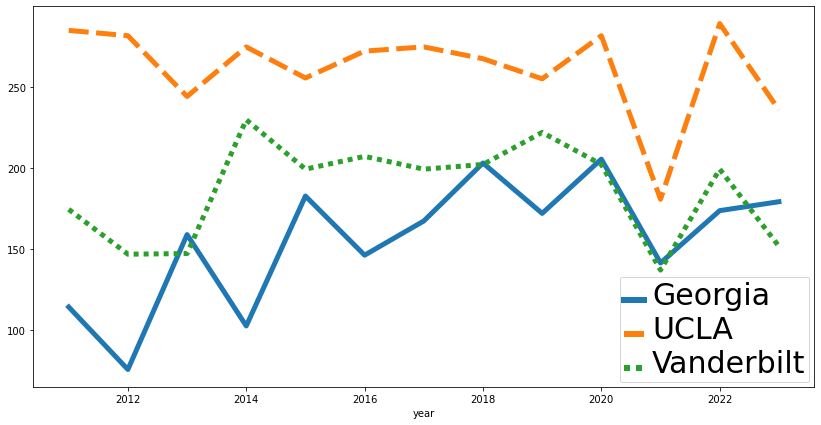

In [191]:
# Get Average Income of recruiting class for chosen colleges each year over time and make line plot

# Groupby school and year, get median Average Income
yearly = final.groupby(['committedTo','year'])['Average Income'].median()

# Make into df
yearly_df = pd.DataFrame(yearly)
yearly_df.reset_index(inplace=True)

# Pivot so that schools are in columns
pivoted = yearly_df.pivot(index='year',columns='committedTo')

# Get rid of multi-indexing
pivoted.columns = pivoted.columns.get_level_values(1)

# Select lists of schools to subset
#schools = ['Georgia','Alabama','LSU']
#schools = ['Stanford','Vanderbilt','Duke','Northwestern','Rice']
schools = ['Georgia','UCLA','Vanderbilt']
#schools = ['Ohio State','Michigan']
#schools = ['UCLA','USC']
#schools = ['Oklahoma','Texas']

# Get schools for line plots based on list above
subset = (pivoted[schools]).divide(1000).round(1)

# Set col names to match school names
subset.columns = schools
#subset.head()

# Create line plot for each school
import seaborn as sns

# Create figure
fig, ax = plt.subplots(figsize=(14, 7))

# Create line plots
lines = sns.lineplot(data=subset,linewidth=5)

# Create and format legend
leg = ax.legend()
for line in leg.get_lines():
    line.set_linewidth(6.0)
plt.setp(lines.get_legend().get_texts(), fontsize='30')

In [192]:
# Calculate highest Average Income by school

# Get data for most recent recruiting class available
most_recent = final_q[final_q['year']==2023]

# Groupby team, get mean Average Income
avg_inc_sort = (most_recent.groupby('committedTo')['Average Income'].mean()).divide(1000).round(1)

# Create df
avg_inc_df = pd.DataFrame(avg_inc_sort.sort_values(ascending=False))
avg_inc_df.reset_index(inplace=True)

# Show top 10
avg_inc_df.head(10)

,committedTo,Average Income
0,Pennsylvania,460.7
1,Central Arkansas,442.3
2,Harvard,437.5
3,Sacramento State,378.3
4,Weber State,376.5
5,San José State,345.5
6,Southern Illinois,327.6
7,Cal Poly,318.1
8,Hawai'i,312.9
9,Washington,304.3


In [193]:
from platform import python_version
print("Python: ",python_version())
print("Pandas:",pd.__version__)
print("Numpy:",np.__version__)
print("Altair:",alt.__version__)
print("Seaborn:",sns.__version__)
#print("Plotly:",plotly.__version__)
import matplotlib as mpl
print("Matplotlib: ",mpl.__version__)

Python:  3.8.3
Pandas: 1.0.5
Numpy: 1.23.5
Altair: 4.2.0
Seaborn: 0.10.1
Matplotlib:  3.4.3
